# **데이터 분석 결과**.ipynb
```
DX트랙 3조의 '투수폼 부상 솔루션' 의사결정 지원을 위한 데이터 분석 결과입니다.

사용된 데이터 목록 (기간: 22.04 ~ 23.05)
- KBO 부상자명단
- KBO 투수 데이터
- MLB 부상 데이터


#**기본설정**

## **라이브러리 불러오기**

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

# Statistics
import scipy.stats as spst

## **플롯 옵션**

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# Apply the font
plt.rc('font', family='NanumBarunGothic') 

title_1 = {
'fontsize': 11,
'fontweight': 'bold'
}
title_2 = {
'fontsize': 9,
'fontweight': 'light'
}

# Seaborn style set
sns.set(font="NanumBarunGothic"         
        ,rc={"axes.unicode_minus":False}  # 마이너스 부호 깨짐 현상 해결
        ,style="white"                    # 그리드가 없는 흰 배경 
        ,context='paper')                 # 가장 작은 스케일

## **데이터 불러오기**

In [ ]:
# KBO 부상자 명단
path = '/content/drive/MyDrive/Pitch_Injury/data/'
il = pd.read_csv(path+'Injured_List.csv')
display(il.sample(3))
print(il.shape)

# KBO 투수 데이터
#p = pd.read_csv(path+'ktwiz_data(begin).CSV', index_col=0)
p = pd.read_csv(path+'ktwiz_data(term).CSV', index_col=0)
#display(p.sample(3))
display(p.sample(3))
print(p.shape)

# MLB 부상 데이터
path = '/content/drive/MyDrive/Pitch_Injury/data/'
ij = pd.read_excel(path+'new.xlsx')
display(ij.sample(3))
print(ij.shape)

,날짜,팀,선수,일수,포지션
37,2023-05-06,KT,김민혁,10,외야수
8,2022-07-29,KIA,장현식,10,투수
52,2022-07-17,LG,홍창기,10,외야수


(206, 5)


,이름,날짜,상대,결과,선발,이닝,실점,자책,타자,타수,...,RE24,WPA,GSC,DEC,간격,년도,월,일,부상이력,간격일수
125,김민수,2022-08-20,KIA,L?2:5,0,0.1,0,0,1,1,...,0.12,0.002,NaN,NaN,4일,2022,8,20,0,4
601,김민,2022-09-28,두산,W?8:0,0,1.0,0,0,3,3,...,0.56,0.001,NaN,NaN,3일,2022,9,28,0,3
679,이선우,2023-05-20,두산,L?0:6,0,1.0,0,0,4,3,...,0.56,0.001,NaN,NaN,1일,2023,5,20,0,1


(729, 35)


,NAME,TEAM,POS,Injury/Surgery Date,Injury/Surgery,Status,IL Retro Date,Eligible to Return,Return Date,Latest Update
808,Tommy Hunter,NYM,RP,09/14/22,Lower back tightness,15-Day IL,09/17/22,2010-02-22 00:00:00,2010-06-22 00:00:00,No timetable for return
767,Cade Cavalli,WSN,SP,08/26/22,Shoulder inflammation,15-Day IL,08/28/22,2009-12-22 00:00:00,2010-06-22 00:00:00,No timetable for return
152,Michael Pineda,DET,SP,07/23/22,Triceps tightness,Activated,07/24/22,2008-08-22 00:00:00,2009-01-22 00:00:00,Activated


(1402, 10)


In [ ]:
# 데이터프레임 추가 정제
temp = ij.loc[ij['Injury/Surgery'].notnull()]
temp.loc[temp['Injury/Surgery'].str.contains('Shoulder'), 'count'] = 1
temp.loc[temp['Injury/Surgery'].str.contains('shoulder'), 'count'] = 1
temp.loc[~temp['Injury/Surgery'].isin([
    'Shoulder soreness', 'Shoulder impingement', 'Shoulder surgery',
    'Shoulder inflammation', 'Shoulder surgery (torn labrum)',
    'Shoulder subluxation', 'Shoulder tendinitis',
    'Shoulder discomfort', 'Shoulder impingement syndrome',
    'Shoulder fatigue', 'Shoulder dislocation (non-throwing)',
    'Shoulder inflammation (scapula)', 'Shoulder contusion',
    'Shoulder surgery (fractured clavicle)',
    'Shoulder surgery (left rotator cuff)',
    'Shoulder dislocation (left)', 'Shoulder tightness',
    'Shoulder bursitis', 'Shoulder soreness (frayed labrum)',
    'Shoulder tendinopathy', 'Shoulder surgery (aneurysm)',
    'Shoulder surgery (frayed labrum)',
    'Shoulder surgery (labrum/rotator cuff repair)',
    'Shoulder surgery (labrum/rotator cuff cleanup)',
    'Shoulder tendinitis (rotator cuff)',
    'Shoulder surgery (rotator cuff)',
    'Strained shoulder', 'Arthroscopic shoulder surgery',
    'Strained shoulder (teres major)', 'Sprained shoulder',
    'Strained shoulder (capsular tear)', 'Stress fracture -- shoulder',
    'Stress reaction -- shoulder',
    'Strained lat/Torn shoulder capsule', 'Dislocated shoulder',
    'Strained shoulder (deltoid)']), 'count'] = 0
temp.sample(2)

,NAME,TEAM,POS,Injury/Surgery Date,Injury/Surgery,Status,IL Retro Date,Eligible to Return,Return Date,Latest Update,count
136,Derek Hill,DET,OF,03/30/22,Strained hamstring,Activated,2004-04-22 00:00:00,04/14/22,04/21/22,Activated,0.0
364,Jalen Beeks,TBR,RP,07/14/22,Lower leg tightness,Activated,07/15/22,07/30/22,07/30/22,Activated,0.0


# **야구선수의 부상 빈도**
`분석 목표`: 팀·선수·포지션 별 최근 시즌 부상 동향을 파악해 솔루션 환경분석에 필요한 근거 마련

### **팀별 부상 빈도**
22'~ 23' 시즌 부상빈도가 가장 높은 상위 5팀은 두산, 롯데, LG, NC, KT로 나타났다.

In [ ]:
# 데이터프레임
team_time = il.groupby(['팀'])[['날짜']].count()
team_days = il.groupby(['팀'])[['일수']].sum()
team = pd.concat([team_time, team_days], axis=1).sort_values(by='날짜', ascending=False).reset_index()
team = team.rename({'날짜':'부상빈도', '일수':'누적부상일'}, axis=1)
team

,팀,부상빈도,누적부상일
0,두산,28,280
1,롯데,27,455
2,LG,25,315
3,NC,25,315
4,KT,24,305
5,삼성,23,340
6,키움,20,340
7,KIA,18,240
8,한화,10,160
9,SSG,6,120


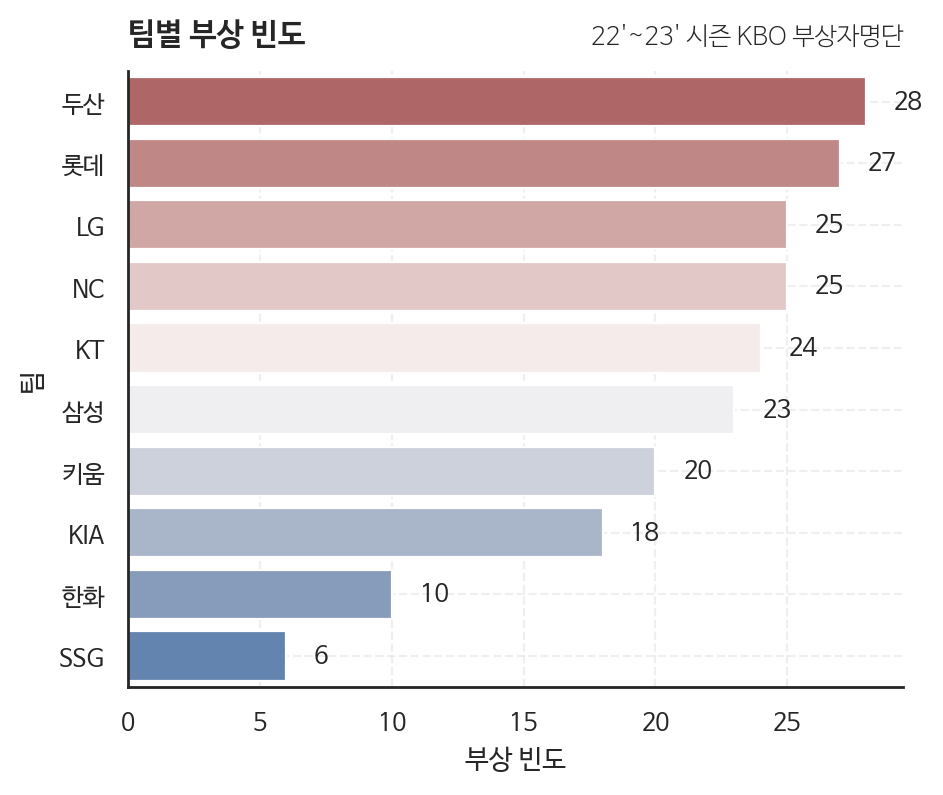

In [ ]:
# 플롯
plt.figure(figsize=(5, 4))
ax = sns.barplot(data=team, y='팀', x='부상빈도', orient='h', palette='vlag_r', zorder=2)
ax.set_title("팀별 부상 빈도", fontdict=title_1, pad=10, loc='left')
ax.set_title("22'~23' 시즌 KBO 부상자명단", fontdict=title_2, pad=10, loc='right')
ax.set_xlabel("부상 빈도")

ax.bar_label(ax.containers[0], padding=10, size=9)   # 팀별 부상 빈도
ax.spines[['right', 'top']].set_visible(False)       # 테두리 제거
ax.grid(True, alpha=0.3, linestyle='--', zorder=1)   # zorder로 위치 순서 변경
plt.show()

### **팀별 부상 누적일수**
22'~ 23' 시즌 부상 누적일수가 가장 높은 상위팀은 롯데(455일), 삼성(340일), 키움, LG(315일), NC, KT(305일) 순으로 나타났다.

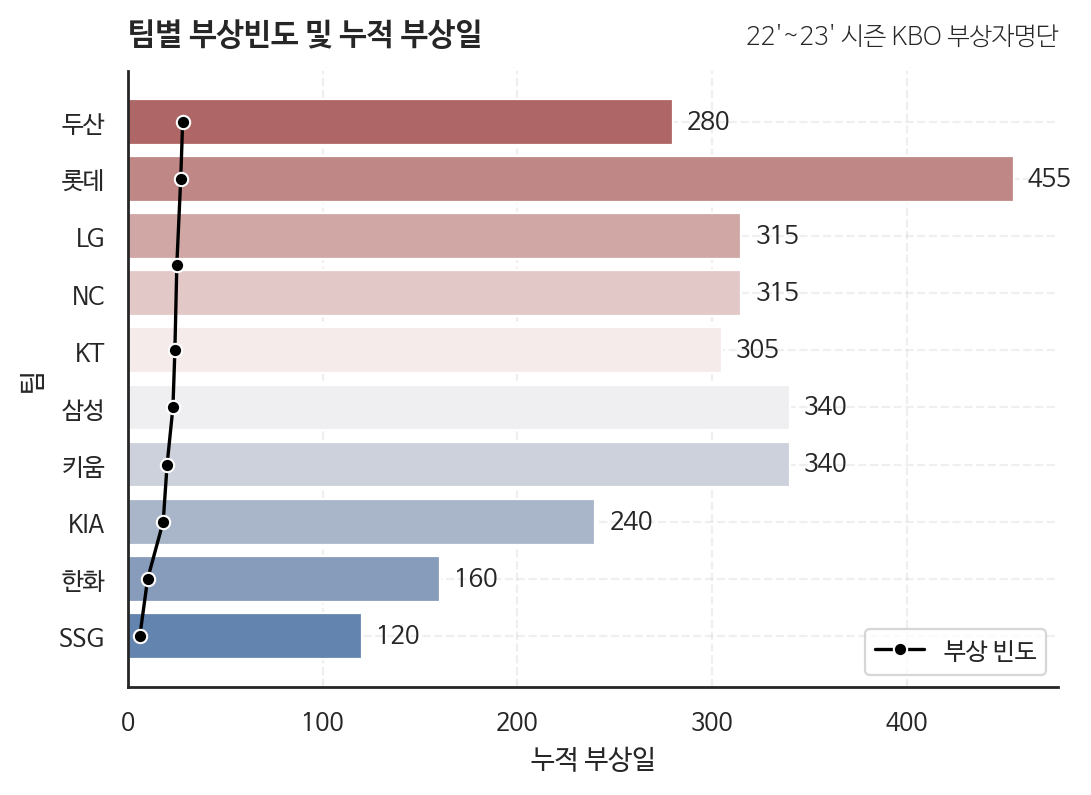

In [ ]:
# 플롯
team = team.sort_values(by=['부상빈도', '누적부상일'], ascending=False).reset_index()
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=team, y='팀', x='누적부상일', orient='h', palette='vlag_r', zorder=2)
ax = sns.lineplot(data=team, y='팀', x='부상빈도', marker='o', color='black', label='부상 빈도', zorder=3)

ax.set_title("팀별 부상빈도 및 누적 부상일", fontdict=title_1, pad=10, loc='left')
ax.set_title("22'~23' 시즌 KBO 부상자명단", fontdict=title_2, pad=10, loc='right')
ax.set_xlabel("누적 부상일")

ax.bar_label(ax.containers[0], padding=5, size=9)   # 팀별 부상 빈도
ax.spines[['right', 'top']].set_visible(False)       # 테두리 제거
ax.legend(loc='lower right')                         # 범례 설정
ax.grid(True, alpha=0.3, linestyle='--', zorder=1)   # zorder로 위치 순서 변경
plt.show()

### **팀별 부상률**
$$부상률(IR) = \frac{총 부상 수} {총 선수 노출} × 1,000 $$
* 1 `선수 노출`(AE): 1명의 선수가 1번의 경기에 참여해 부상당할 가능성에 노출되는 것

In [ ]:
# KBO 스탯 데이터 추가 확보 시 진행

### **팀별 부상으로 인한 손실승수**
부상당한 선수들의 WAR를 이용해 손실승수 계산 예정

In [ ]:
# KBO 스탯 데이터 추가 확보 시 진행

### **선수별 부상 빈도**
부상횟수가 가장 많은 선수 상위 3인은 김인해(두산), 장운호(한화), 고우석(LG) 으로 나타났다.   
정규 시즌은 약 6개월 간 진행되므로 누적 부상일이 60일, 30일일 경우 해당 선수는 약 1/3, 1/6 가량 시즌에 참여를 할 수 없게 된다.

In [ ]:
# 데이터프레임
player_time = il.groupby(['선수'])[['날짜']].count()
player_days = il.groupby(['선수'])[['일수']].sum()
player = pd.concat([player_time, player_days], axis=1)
player = player.rename({'날짜':'부상빈도', '일수':'누적부상일'}, axis=1).sort_values(by=['부상빈도', '누적부상일'], ascending=False).reset_index()
player = player.merge(il[['팀', '선수']], on='선수', how='inner').drop_duplicates().reset_index(drop=True)
player['평균부상일'] = round((player['부상빈도'] / player['누적부상일'] * 100), 2)
player_top20 = player.iloc[:21,:]
player.head()

,선수,부상빈도,누적부상일,팀,평균부상일
0,김인태,6,60,두산,10.00
1,장운호,3,35,한화,8.57
2,고우석,3,30,LG,10.00
3,곽빈,3,30,두산,10.00
4,구자욱,3,30,삼성,10.00


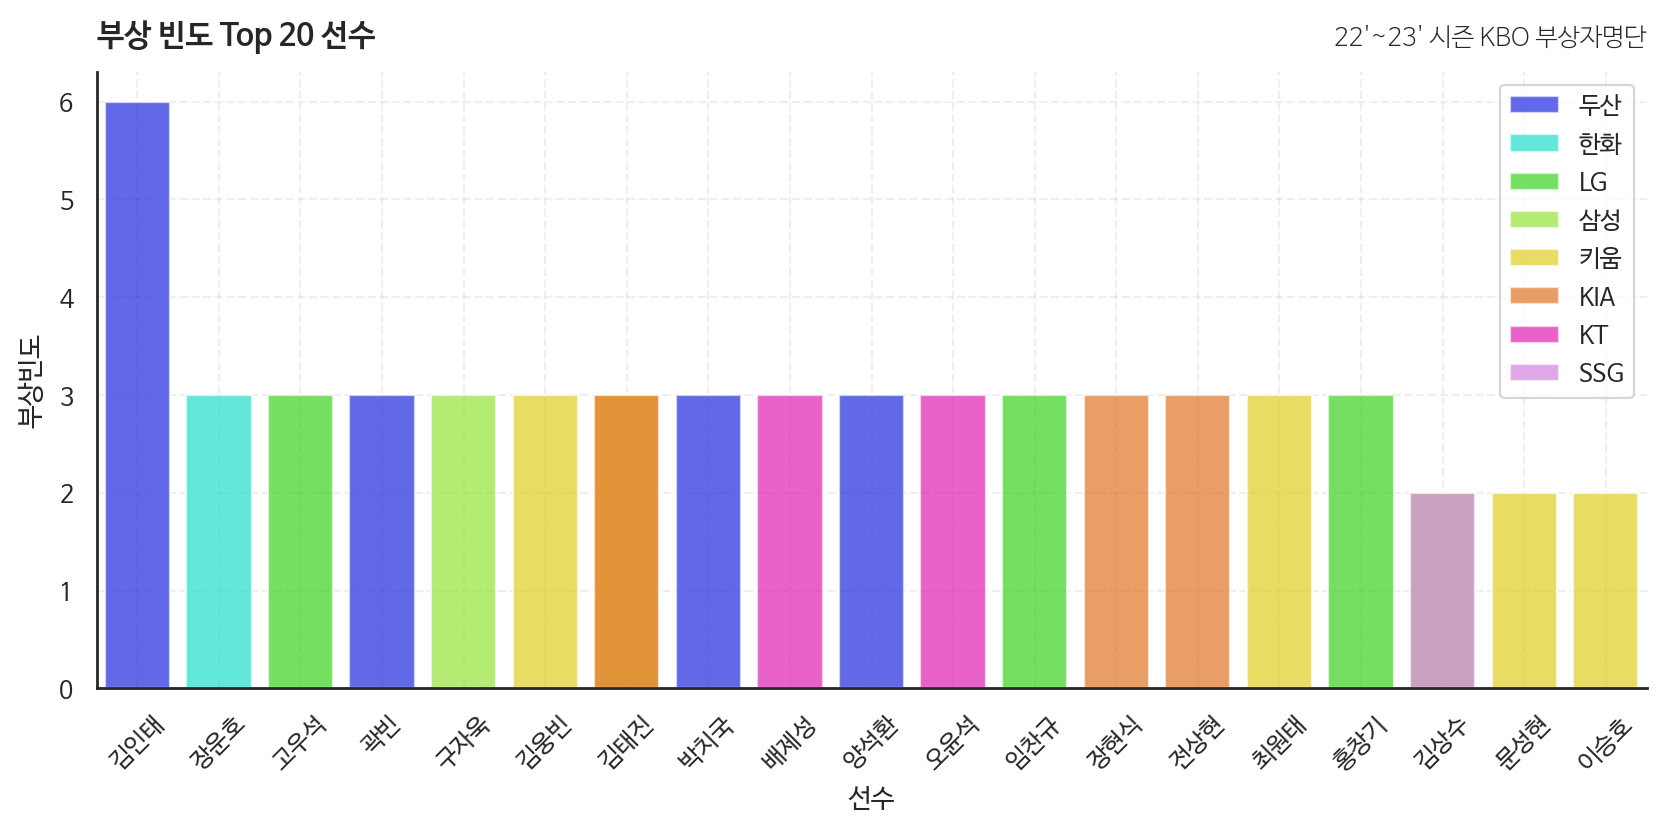

In [ ]:
# 플롯
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=player_top20, x='선수', y='부상빈도', hue='팀', palette='gist_ncar', alpha=.7, dodge=False, zorder=2)
ax.set_title("부상 빈도 Top 20 선수", fontdict=title_1, pad=10, loc='left')
ax.set_title("22'~23' 시즌 KBO 부상자명단", fontdict=title_2, pad=10, loc='right')
ax.set_xlabel("선수")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.spines[['right', 'top']].set_visible(False)       # 테두리 제거
ax.grid(True, alpha=0.3, linestyle='--', zorder=1)   # zorder로 위치 순서 변경
ax.legend(loc='upper right')
plt.show()

# **야구선수의 포지션에 따른 부상 분석**
`분석 목표`: "왜 투수 솔루션인가?", "왜 솔루션이 어깨와 팔꿈치 부상에 집중해야하는가?" 에 답하기 위한 근거 마련

### **포지션별 부상 빈도**
포지션별 부상 빈도는 투수가 91회, 내야수 57회, 외야수 49회, 포수 9회로 **투수의 부상비율**은 51.5%에 달하는 것으로 나타났다.

In [ ]:
# 데이터프레임
position_time = il.groupby(['포지션'])[['날짜']].count()
position_days = il.groupby(['포지션'])[['일수']].sum()
position = pd.concat([position_time, position_days], axis=1)
position = position.rename({'날짜':'부상빈도', '일수':'누적부상일'}, axis=1).sort_values(by=['부상빈도', '누적부상일'], ascending=False).reset_index()
position['평균부상일'] = round((position['부상빈도'] / position['누적부상일'] * 100), 2)
position.head()

,포지션,부상빈도,누적부상일,평균부상일
0,투수,91,1310,6.95
1,내야수,57,780,7.31
2,외야수,49,645,7.60
3,포수,9,135,6.67


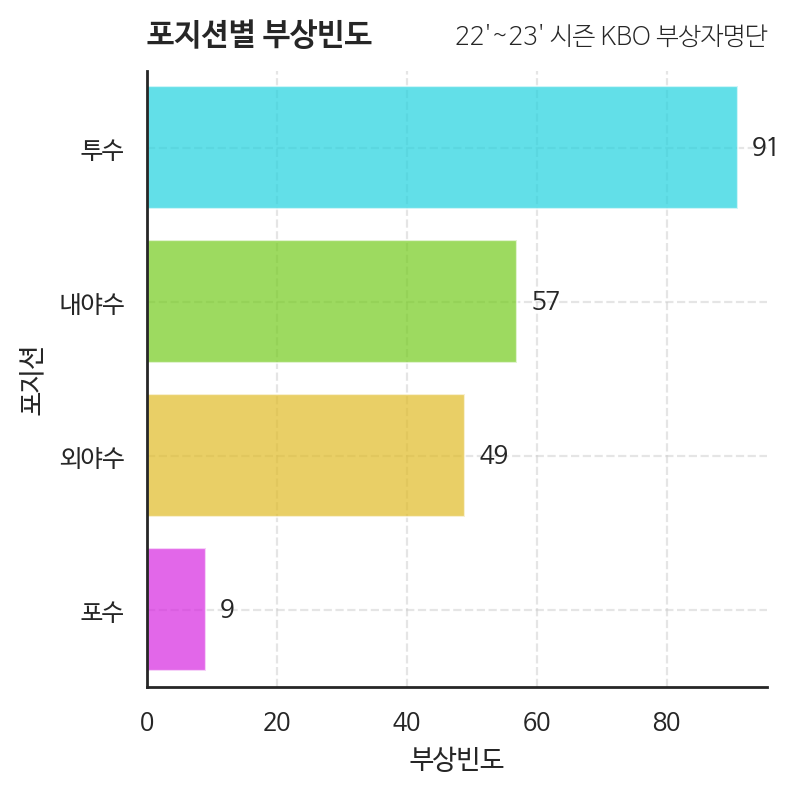

In [ ]:
# 플롯
plt.figure(figsize=(4, 4))
ax = sns.barplot(data=position, y='포지션', x='부상빈도', orient='h', palette='gist_ncar', alpha=.7, zorder=2)
ax.set_title("포지션별 부상빈도", fontdict=title_1, loc='left')
ax.set_title("22'~23' 시즌 KBO 부상자명단", fontdict=title_2, pad=10, loc='right')

ax.bar_label(ax.containers[0], padding=5, size=9)   # 포지션별 부상 빈도
ax.spines[['right', 'top']].set_visible(False)      # 테두리 제거
ax.grid(True, alpha=0.5, linestyle='--', zorder=1)   # zorder로 위치 순서 변경
plt.show()

## **포지션별 부상 부위**

### **가설1 : 포지션별 어깨 관절에서 발생한 부상 빈도**
$$ X_i = 포지션, 부상 부위(어깨) $$
$$ y = 부상 빈도 $$
`H0` : 포지션별로 어깨 관절에서 발생한 부상 빈도수에 차이가 없다  
`H1` : 포지션별로 어깨 관절에서 발생한 부상 빈도수에 차이가 있다  

---

`결과 및 해설` : F 통계량 3.327, p-value 9.105e-06 으로 대립가설 채택    

포지션별 어깨 관절에서 발생한 부상 빈도수에는 유의미한 차이가 있다.   
즉, **어깨 부상의 80%를 투수가 차지**할 정도로 어깨 부상은 투수 포지션의 주요 부상 특성이다.    
따라서 투수의 부상 솔루션은 어깨 부상에 집중해야할 필요가 있다.

In [ ]:
# 그룹 추출
A_1 = temp.loc[temp['POS'].isin(['SP', 'RP', 'SP/RP']), 'count']   # 투수 POS
A_2 = temp.loc[temp['POS'] == 'OF', 'count']
A_3 = temp.loc[temp['POS'] == 'INF', 'count']
A_4 = temp.loc[temp['POS'] == 'C', 'count']
A_5 = temp.loc[temp['POS'] == 'INF/OF', 'count']
A_6 = temp.loc[temp['POS'] == '3B', 'count']
A_7 = temp.loc[temp['POS'] == '1B', 'count']
A_8 = temp.loc[temp['POS'] == 'SS', 'count']
A_9 = temp.loc[temp['POS'] == 'OF/INF', 'count']
A_10 = temp.loc[temp['POS'] == '2B', 'count']
A_11 = temp.loc[temp['POS'] == 'C/OF', 'count']
A_12 = temp.loc[temp['POS'] == 'OF/1B', 'count']
A_13 = temp.loc[temp['POS'] == '1B/OF', 'count']
A_14 = temp.loc[temp['POS'] == 'C/1B', 'count']
A_15 = temp.loc[temp['POS'] == '3B/1B', 'count']
A_16 = temp.loc[temp['POS'] == '3B/OF', 'count']
A_17 = temp.loc[temp['POS'] == 'DH', 'count']

# 일원분산분석 - 샘플의 크기가 서로 다른 3개 그룹 간 평균에 차이가 존재하는지 여부를 검정
spst.f_oneway(A_1, A_2, A_3, A_4, A_5, A_6, A_7, A_8, A_9, A_10, A_11, A_12, A_13, A_14, A_15, A_16, A_17)

F_onewayResult(statistic=3.32696395645334, pvalue=9.10450669106653e-06)

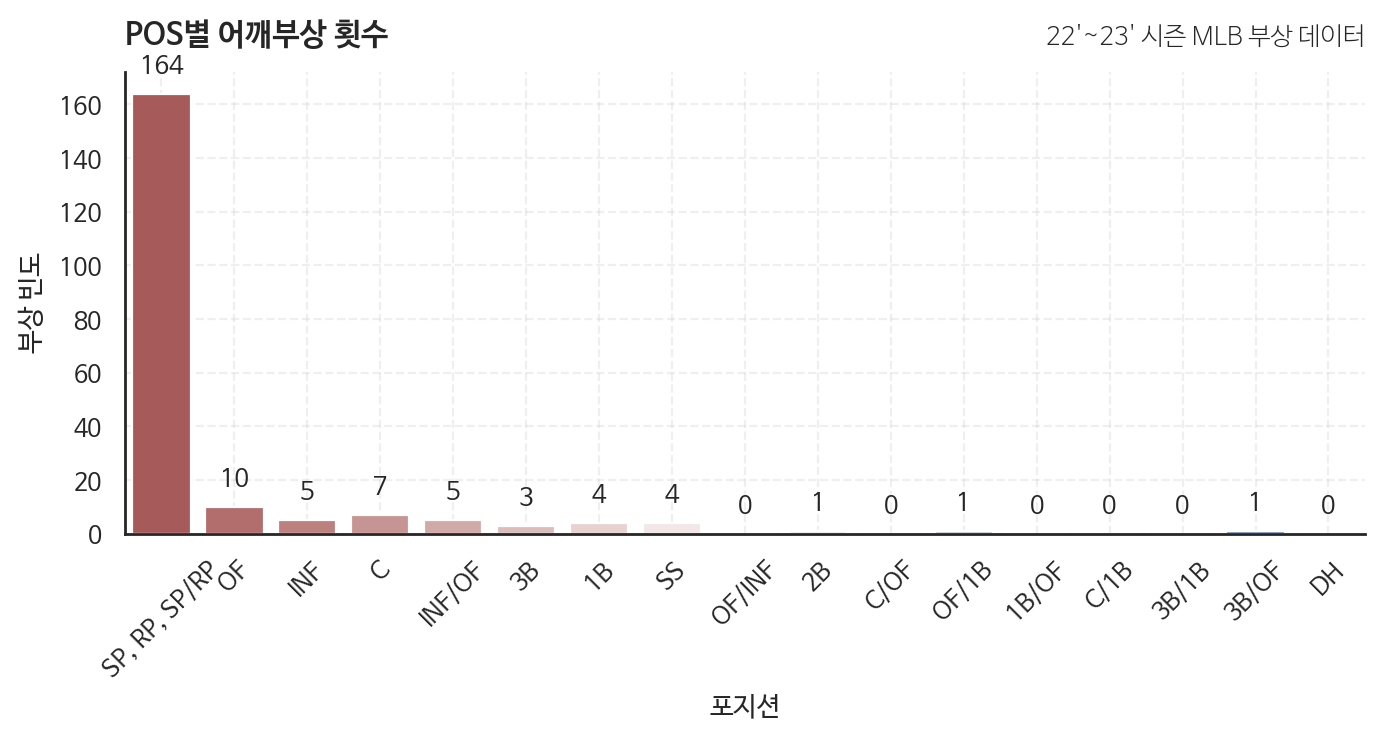

In [ ]:
# 플롯
pos_labels = ['SP, RP, SP/RP', 'OF', 'INF', 'C', 'INF/OF', '3B', '1B', 'SS', 'OF/INF',
              '2B', 'C/OF', 'OF/1B', '1B/OF', 'C/1B', '3B/1B', '3B/OF', 'DH']

## POS별 빈도
count_values = [temp.loc[temp['POS'].isin(['SP', 'RP', 'SP/RP']), 'count'].sum(),
               temp.loc[temp['POS'] == 'OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'INF', 'count'].sum(),
               temp.loc[temp['POS'] == 'C', 'count'].sum(),
               temp.loc[temp['POS'] == 'INF/OF', 'count'].sum(),
               temp.loc[temp['POS'] == '3B', 'count'].sum(),
               temp.loc[temp['POS'] == '1B', 'count'].sum(),
               temp.loc[temp['POS'] == 'SS', 'count'].sum(),
               temp.loc[temp['POS'] == 'OF/INF', 'count'].sum(),
               temp.loc[temp['POS'] == '2B', 'count'].sum(),
               temp.loc[temp['POS'] == 'C/OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'OF/1B', 'count'].sum(),
               temp.loc[temp['POS'] == '1B/OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'C/1B', 'count'].sum(),
               temp.loc[temp['POS'] == '3B/1B', 'count'].sum(),
               temp.loc[temp['POS'] == '3B/OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'DH', 'count'].sum()]
## 플롯 그리기
plt.figure(figsize=(8, 3))
ax = sns.barplot(data=temp, x=pos_labels, y=count_values, palette='vlag_r')
ax.set_title("POS별 어깨 부상 횟수", fontdict=title_1, pad=10, loc='left')
ax.set_title("22'~23' 시즌 MLB 부상 데이터", fontdict=title_2, pad=10, loc='right')
ax.set_xlabel("포지션")
ax.set_ylabel("부상 빈도")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.bar_label(ax.containers[0], padding=5, size=9)   # 팀별 부상 빈도
ax.spines[['right', 'top']].set_visible(False)       # 테두리 제거
ax.grid(True, alpha=0.3, linestyle='--', zorder=1)   # zorder로 위치 순서 변경
plt.show()

### **가설2 : 포지션별 팔꿈치 관절에서 발생한 부상 빈도**
$$ X_i = 포지션, 부상 부위(팔꿈치) $$
$$ y = 부상 빈도 $$
`H0` : 포지션별로 팔꿈치 관절에서 발생한 부상 빈도수에 차이가 없다  
`H1` : 포지션별로 팔꿈치 관절에서 발생한 부상 빈도수에 차이가 있다

---

`결과 및 해설` : F 통계량 2.974, p-value 6.764e-05 으로 대립가설 채택    

포지션별 팔꿈치 관절에서 발생한 부상 빈도수에는 유의미한 차이가 있다.   
즉, **팔꿈치 부상의 89%를 투수가 차지**할 정도로 팔꿈치 부상은 투수 포지션의 주요 부상 특성이다.    
따라서 투수의 부상 솔루션은 팔꿈치 부상에 집중해야할 필요가 있다.

In [ ]:
# 분석용 데이터프레임 정제
temp.loc[temp['Injury/Surgery'].str.contains('elbow'), 'count'] = 1
temp.loc[temp['Injury/Surgery'].str.contains('Elbow'), 'count'] = 1
temp.loc[temp['Injury/Surgery'].str.contains('Tommy John'), 'count'] = 1
temp.loc[~temp['Injury/Surgery'].isin([
    'Fractured elbow (right)', 'Strained elbow', 'Sprained elbow',
    'Olecranon stress fracture (right elbow)', 'Fractured elbow',
    'Arthroscopic elbow surgery',
    'Blood clot removal surgery (right elbow)',
    'Arthoscopic elbow surgery', 'Stress reaction -- elbow',
    'Strained elbow flexor', 'Bone chip in elbow','Elbow inflammation', 'Elbow contusion', 'Elbow discomfort',
    'Elbow debridement surgery', 'Elbow surgery (fracture)',
    'Elbow tendinitis', 'Elbow discomfort (loose bodies)',
    'Elbow soreness', 'Elbow/back soreness', 'Elbow surgery',
    'Elbow discomfort (lateral epicondylitis)',
    'Elbow inflammation (left)', 'Elbow tightness', 'Elbow effusion',
    'Elbow surgery (internal brace procedure)',
    'Elbow stress reaction', 'Elbow discomfort (ulnar neuritis)',
    'Elbow surgery (internal brace)',
    'Elbow surgery (ulnar nerve transposition)',
    'Elbow discomfort (ulnar nerve entrapment)',
    'Elbow valgus extension overload',
    'Elbow surgery (bone chip removal)', 'Elbow nerve irritation']), 'count'] = 0

In [ ]:
# 그룹 추출
A_1 = temp.loc[temp['POS'].isin(['SP', 'RP', 'SP/RP']), 'count']
A_2 = temp.loc[temp['POS'] == 'OF', 'count']
A_3 = temp.loc[temp['POS'] == 'INF', 'count']
A_4 = temp.loc[temp['POS'] == 'C', 'count']
A_5 = temp.loc[temp['POS'] == 'INF/OF', 'count']
A_6 = temp.loc[temp['POS'] == '3B', 'count']
A_7 = temp.loc[temp['POS'] == '1B', 'count']
A_8 = temp.loc[temp['POS'] == 'SS', 'count']
A_9 = temp.loc[temp['POS'] == 'OF/INF', 'count']
A_10 = temp.loc[temp['POS'] == '2B', 'count']
A_11 = temp.loc[temp['POS'] == 'C/OF', 'count']
A_12 = temp.loc[temp['POS'] == 'OF/1B', 'count']
A_13 = temp.loc[temp['POS'] == '1B/OF', 'count']
A_14 = temp.loc[temp['POS'] == 'C/1B', 'count']
A_15 = temp.loc[temp['POS'] == '3B/1B', 'count']
A_16 = temp.loc[temp['POS'] == '3B/OF', 'count']
A_17 = temp.loc[temp['POS'] == 'DH', 'count']

# 일원분산분석 - 샘플의 크기가 서로 다른 3개 그룹 간 평균에 차이가 존재하는지 여부를 검정
spst.f_oneway(A_1, A_2, A_3, A_4, A_5, A_6, A_7, A_8, A_9, A_10, A_11, A_12, A_13, A_14, A_15, A_16, A_17)

F_onewayResult(statistic=2.9739147906156793, pvalue=6.763657871035487e-05)

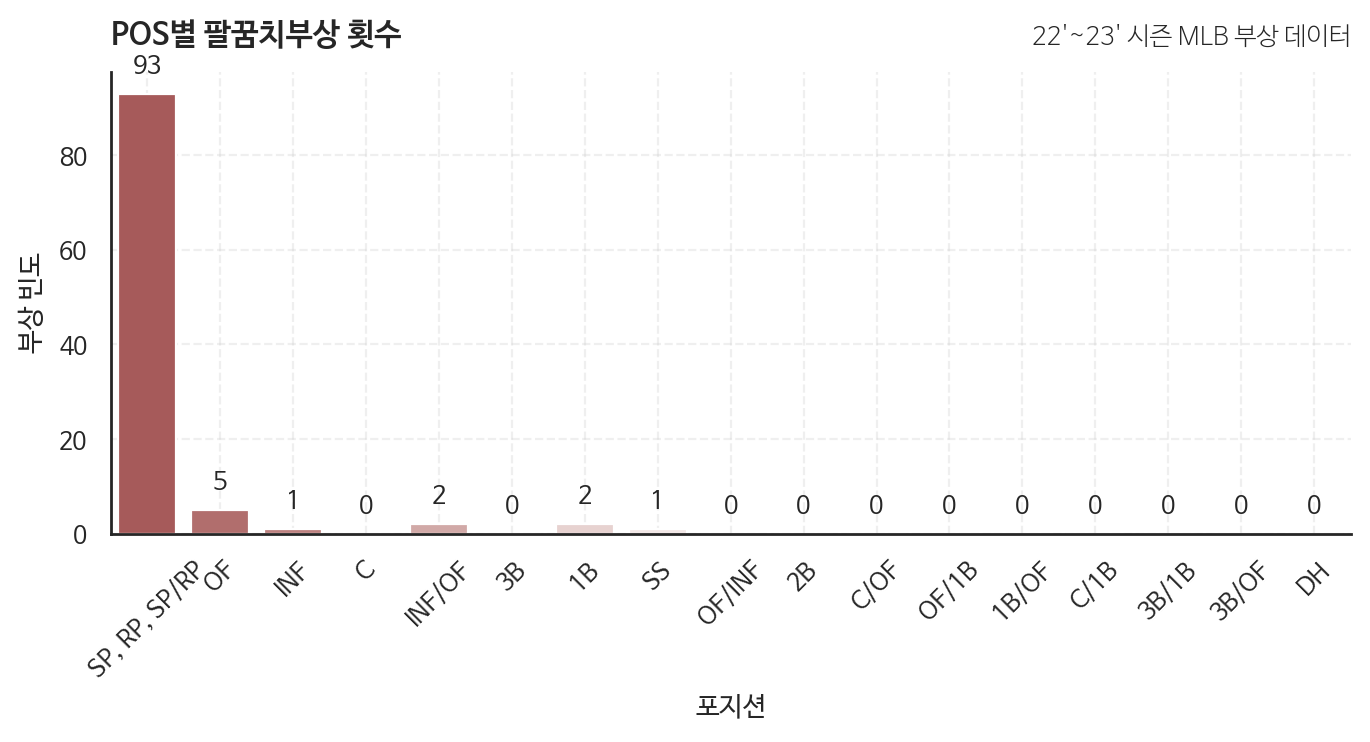

In [ ]:
# 플롯
pos_labels = ['SP, RP, SP/RP', 'OF', 'INF', 'C', 'INF/OF', '3B', '1B', 'SS', 'OF/INF',
              '2B', 'C/OF', 'OF/1B', '1B/OF', 'C/1B', '3B/1B', '3B/OF', 'DH']

## POS별 빈도
count_values = [temp.loc[temp['POS'].isin(['SP', 'RP', 'SP/RP']), 'count'].sum(),
               temp.loc[temp['POS'] == 'OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'INF', 'count'].sum(),
               temp.loc[temp['POS'] == 'C', 'count'].sum(),
               temp.loc[temp['POS'] == 'INF/OF', 'count'].sum(),
               temp.loc[temp['POS'] == '3B', 'count'].sum(),
               temp.loc[temp['POS'] == '1B', 'count'].sum(),
               temp.loc[temp['POS'] == 'SS', 'count'].sum(),
               temp.loc[temp['POS'] == 'OF/INF', 'count'].sum(),
               temp.loc[temp['POS'] == '2B', 'count'].sum(),
               temp.loc[temp['POS'] == 'C/OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'OF/1B', 'count'].sum(),
               temp.loc[temp['POS'] == '1B/OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'C/1B', 'count'].sum(),
               temp.loc[temp['POS'] == '3B/1B', 'count'].sum(),
               temp.loc[temp['POS'] == '3B/OF', 'count'].sum(),
               temp.loc[temp['POS'] == 'DH', 'count'].sum()]

## 플롯 그리기
plt.figure(figsize=(8, 3))
ax = sns.barplot(data=temp, x=pos_labels, y=count_values, palette='vlag_r')
ax.set_title("POS별 팔꿈치 부상 횟수", fontdict=title_1, pad=10, loc='left')
ax.set_title("22'~23' 시즌 MLB 부상 데이터", fontdict=title_2, pad=10, loc='right')
ax.set_xlabel("포지션")
ax.set_ylabel("부상 빈도")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.bar_label(ax.containers[0], padding=5, size=9)   # 팀별 부상 빈도
ax.spines[['right', 'top']].set_visible(False)       # 테두리 제거
ax.grid(True, alpha=0.3, linestyle='--', zorder=1)   # zorder로 위치 순서 변경
plt.show()

# **투수의 스탯에 따른 부상 분석**
`분석 목표` : 투수의 부상에 영향을 주는 요인을 찾아 지표를 수립하기 위한 사전 작업

### **가설3-1 : 부상유무별 투수가 던진 공의 수 차이**
$$ X_i = 던진 공의 수 $$
$$ y = 부상 유무(있음 - 1, 없음 - 0) $$
(단, '부상 있음'은 부상자 명단 등록 전 1개월을 기준으로 함)

`H0` : 부상유무에 따라 투수가 던진 공의 수의 평균에 차이가 없다    
`H1` : 부상유무에 따라 투수가 던진 공의 수의 평균에 차이가 있다

---

`결과 및 해설` : t 통계량 27.819, p-value 1.346e-116 으로 대립가설 채택    

부상 직전 한달 간 투수가 던진 공의 수와 부상이 없는 시기에 던진 공의 수는 차이가 있다.   
부상은 하나의 시점이 아닌 연속된 운동부하에 의한 결과이다.    
따라서 부상일 직전 한달 간 던진 공의 개수를 운동부하의 주요 요인으로 보았을 때, **투수가 던진 공의 수는 부상여부와 관련**이 있다고 추론할 수 있다.    
이후 상관분석을 통해 이점을 더 명확히 확인할 필요가 있다.

In [ ]:
# T-test : 두 그룹의 평균이 서로 유의하게 다른지 여부를 검정

spst.ttest_ind(p['투구수'], p['부상이력'], equal_var=False)

Ttest_indResult(statistic=27.819450118494256, pvalue=1.3456257553437583e-116)

### **가설3-2 : 부상유무별 투수(선발/불펜)가 던진 공의 수 차이**
$$ X_i = 던진 공의 수 $$
$$ y = 부상 유무(있음 - 1, 없음 - 0) $$
(단, '부상 있음'은 부상자 명단 등록 전 1개월을 기준으로 함)

`H0` : 부상유무에 따라 투수(선발/불펜)가 던진 공의 수의 평균에 차이가 없다    
`H1` : 부상유무에 따라 투수(선발/불펜)가 던진 공의 수의 평균에 차이가 있다

---

`결과 및 해설` :    
* 선발 투수 - t 통계량 83.950, p-value 9.022e-140 으로 대립가설 채택    
* 불펜 투수 - t 통계량 42.158, p-value 1.297e-175 으로 대립가설 채택    

가설 3-1에서 투수 보직을 세분화한 가설 3-2 또한 같은 결과를 얻었다.
투수의 보직에 따라 투구시 상황과 투구력에 차이가 존재할 것으로 판단했으나, 부상유무에 따른 던진 공의 개수 차이는 여전히 존재하는 것으로 나타났다.

In [ ]:
# 투수 POS
p_b = p[p['선발']==0]   # 불펜 투수
p_s = p[p['선발']==1]   # 선발 투수

# T-test : 두 그룹의 평균이 서로 유의하게 다른지 여부를 검정
print('선발 투수의 투구수와 부상이력 t-test',
      spst.ttest_ind(p_s['투구수'], p_s['부상이력'], equal_var=False)[0], 'pvalue=', spst.ttest_ind(p_s['투구수'], p_s['부상이력'], equal_var=False)[1])
print('불펜 투수의 투구수와 부상이력 t-test',
      spst.ttest_ind(p_b['투구수'], p_b['부상이력'], equal_var=False)[0], 'pvalue=', spst.ttest_ind(p_b['투구수'], p_b['부상이력'], equal_var=False)[1])

선발 투수의 투구수와 부상이력 t-test 83.9503741117231 pvalue= 9.021939353344716e-140
불펜 투수의 투구수와 부상이력 t-test 42.157561878263024 pvalue= 1.2972194715775906e-175


### **가설4 : 부상유무 그룹의 출전 간격일수 차이**
$$ X_i = 출전 간격일수 $$
$$ y = 부상 유무(있음 - 1, 없음 - 0) $$
(단, '부상 있음'은 부상자 명단 등록 전 1개월을 기준으로 함)

`H0` : 부상유무에 따라 투수(선발/불펜)의 출전 간격일수에 차이가 없다    
`H1` : 부상유무에 따라 투수(선발/불펜)의 출전 간격일수에 차이가 있다

---

`결과 및 해설` : 
- 선발 투수 - t 통계량 19.064, p-value 4.545e-44 으로 대립가설 채택    
- 불펜 투수 - t 통계량 35.044, p-value 2.214e-143 으로 대립가설 채택

가설 4에서는 출전 간격이 짧은 투수들이 부상 확률이 높을 것으로 예상하였고, 예상과 같은 결과를 얻었다.
선발투수와 불펜투수 모두 출전 간격이 짧을수록 부상 확률이 높다는 결과가 나왔다



In [ ]:
# T-test : 두 그룹의 평균이 서로 유의하게 다른지 여부를 검정

print('선발 투수의 간격일수와 부상이력 t-test', 
      spst.ttest_ind(p_s['간격일수'], p_s['부상이력'], equal_var=False)[0],'pvalue=', spst.ttest_ind(p_s['간격일수'], p_s['부상이력'], equal_var=False)[1])
print('불펜 투수의 간격일수와 부상이력 t-test', 
      spst.ttest_ind(p_b['간격일수'], p_b['부상이력'], equal_var=False)[0],'pvalue=', spst.ttest_ind(p_b['간격일수'], p_b['부상이력'], equal_var=False)[1])

선발 투수의 간격일수와 부상이력 t-test 19.064240462099114 pvalue= 4.545270343468535e-44
불펜 투수의 간격일수와 부상이력 t-test 35.044326726860504 pvalue= 2.2138250190029385e-143


### **가설5 : 부상유무 그룹의 ERA 차이**
$$ X_i = ERA $$
$$ y = 부상 유무(있음 - 1, 없음 - 0) $$
(단, '부상 있음'은 부상자 명단 등록 전 1개월을 기준으로 함)

`H0` : 부상유무에 따라 투수(선발/불펜)의 ERA 평균에 차이가 없다    
`H1` : 부상유무에 따라 투수(선발/불펜)의 ERA 평균에 차이가 있다

---

`결과 및 해설` : 
- 선발 투수 - t 통계량 15.550, p-value 1.4195e-34 으로 대립가설 채택    
- 불펜 투수 - t 통계량 11.905, p-value 2.806e-29 으로 대립가설 채택 

ERA는 투수의 9이닝당 평균 자책점을 나타낸 수치이다.<br>
가설 5에서는 투수가 부상 전후로 ERA 변화가 일어나 퍼포먼스 저하가 일어날 것으로 대립가설을 세웠고, <br>결과적으로 선발투수와 불펜투수 모두 ERA 하락이 일어났다.
이로 인해 투수는 부상을 겪은 이후 경기력이 하락한다는 것을 유추할 수 있다.

In [ ]:
print('선발 투수의 ERA와 부상이력 t-test', spst.ttest_ind(p_s['ERA'], p_s['부상이력'], equal_var=False))
print('불펜 투수의 ERA와 부상이력 t-test', spst.ttest_ind(p_b['ERA'], p_b['부상이력'], equal_var=False))

선발 투수의 ERA와 부상이력 t-test Ttest_indResult(statistic=15.550453202879156, pvalue=1.419451472345634e-34)
불펜 투수의 ERA와 부상이력 t-test Ttest_indResult(statistic=11.904718274228411, pvalue=2.80564417896836e-29)


### **가설6 : 부상유무 그룹의 WPA 차이**
$$ X_i = WPA $$
$$ y = 부상 유무(있음 - 1, 없음 - 0) $$
(단, '부상 있음'은 부상자 명단 등록 전 1개월을 기준으로 함)

`H0` : 부상유무에 따라 투수(선발/불펜)의 WPA 평균에 차이가 없다    
`H1` : 부상유무에 따라 투수(선발/불펜)의 WPA 평균에 차이가 있다

---

`결과 및 해설` : 
- 선발 투수 - t 통계량 -1.554, p-value 0.121 으로 대립가설 기각    
- 불펜 투수 - t 통계량 -0.193, p-value 0.847 으로 대립가설 기각 

WPA(WIn Percentage Added)는 플레이별로 한 경기당 승리에 결정적으로 얼마나 큰 영향을 미치는 지에 대한 수치이다.<br>
가설 6에서는 투수의 부상 유무에 따라 WPA 차이가 있을 것으로 예측을 하였다.
결론적으로 WPA는 투수의 부상 유무와는 관계가 없으며, WPA라는 수치가 제공하는 주요 기능인 '클러치 능력' 은 부상과는 관계가 없음을 확인하였다.

In [ ]:
print('선발 투수의 WPA와 부상이력 t-test', spst.ttest_ind(p_s['WPA'], p_s['부상이력'], equal_var=False))
print('불펜 투수의 WPA와 부상이력 t-test', spst.ttest_ind(p_b['WPA'], p_b['부상이력'], equal_var=False))

선발 투수의 WPA와 부상이력 t-test Ttest_indResult(statistic=-1.5542506292480764, pvalue=0.12106403519871207)
불펜 투수의 WPA와 부상이력 t-test Ttest_indResult(statistic=-0.1927019349307239, pvalue=0.8472299966090315)


### **가설7 : 부상유무 그룹의 이닝수 차이**
$$ X_i = 이닝 수 $$
$$ y = 부상 유무(있음 - 1, 없음 - 0) $$
(단, '부상 있음'은 부상자 명단 등록 전 1개월을 기준으로 함)

`H0` : 부상유무에 따라 투수(선발/불펜)가 던진 이닝 수에 차이가 없다    
`H1` : 부상유무에 따라 투수(선발/불펜)가 던진 이닝 수에 차이가 있다

---

`결과 및 해설` : 
- 선발 투수 - t 통계량 19.064, p-value 4.545e-44 으로 대립가설 채택    
- 불펜 투수 - t 통계량 35.044, p-value 2.214e-143 으로 대립가설 채택 

먼저, 선발투수와 불펜투수가 1년간 소화하는 평균 이닝 수가 편차가 크기 떄문에 두 그룹에 대해 나눠서 t-test를 진행하였다.<br>
많은 이닝 수를 소화한 투수가 부상 확률이 높을 것으로 대립가설을 세웠고. t-test 결과 대립가설을 채택하였다.


In [ ]:
print('선발 투수의 이닝수와 부상이력 t-test', spst.ttest_ind(p_s['이닝'], p_s['부상이력'], equal_var=False))
print('불펜 투수의 이닝수와 부상이력 t-test', spst.ttest_ind(p_b['이닝'], p_b['부상이력'], equal_var=False))

선발 투수의 이닝와 부상이력 t-test Ttest_indResult(statistic=50.43690282146607, pvalue=7.573257983081637e-108)
불펜 투수의 이닝와 부상이력 t-test Ttest_indResult(statistic=34.52003708698513, pvalue=9.244662855397027e-144)
